In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import yfinance as yf
from datetime import datetime,timedelta

C:\Users\arnim\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Input stock symbol and date range
stock_symbol = input("Enter stock symbol: ")
start_date_str = input("Enter the start date (YYYY-MM-DD): ")
end_date_str = input("Enter the end date (YYYY-MM-DD): ")

# Convert date strings to datetime objects
start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.strptime(end_date_str, "%Y-%m-%d")

# Fetch stock price data from Yahoo Finance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date)

Enter stock symbol: DEO
Enter the start date (YYYY-MM-DD): 1999-01-23
Enter the end date (YYYY-MM-DD): 2023-01-08
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Extract the "Close" prices for training
training_set = stock_data["Close"].values

# Reshape and scale the training data
scaler = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
scaled_training_set = scaler.fit_transform(training_set)

# Prepare training sequences
X_train, y_train = [], []

In [4]:
for i in range(60, len(scaled_training_set)):
    X_train.append(scaled_training_set[i - 60:i, 0])
    y_train.append(scaled_training_set[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)


In [5]:
# Create and compile the LSTM model
regressor = Sequential()
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units=50, return_sequences=False))
regressor.add(Dropout(0.2))
regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train the model
regressor.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
187/187 [==============================] - 11s 40ms/step - loss: 0.0075
Epoch 2/100
187/187 [==============================] - 7s 40ms/step - loss: 0.0021
Epoch 3/100
187/187 [==============================] - 7s 40ms/step - loss: 0.0019
Epoch 4/100
187/187 [==============================] - 7s 40ms/step - loss: 0.0017
Epoch 5/100
 84/187 [============>.................] - ETA: 4s - loss: 0.0017

In [7]:
# Prepare test data
test_dataset = stock_data["Open"].values
test_dataset = test_dataset.reshape(-1, 1)
scaled_test_data = scaler.transform(test_dataset)

X_test = []

for i in range(60, 80):
    X_test.append(scaled_test_data[i - 60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [8]:
# Predict the stock prices
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

1/1 [==============================] - 1s 809ms/step


In [9]:
# Extract the actual test data (Open prices)
actual_stock_price = test_dataset[60:80]

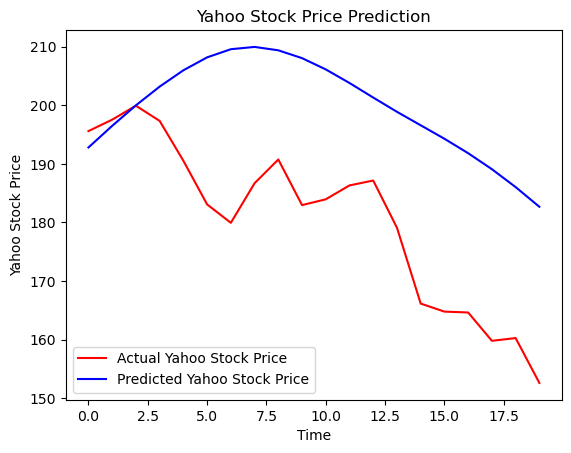

In [10]:

# Plot the actual and predicted stock prices
plt.plot(actual_stock_price, color='red', label='Actual Yahoo Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Yahoo Stock Price')
plt.title('Yahoo Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Yahoo Stock Price')
plt.legend()
plt.show()


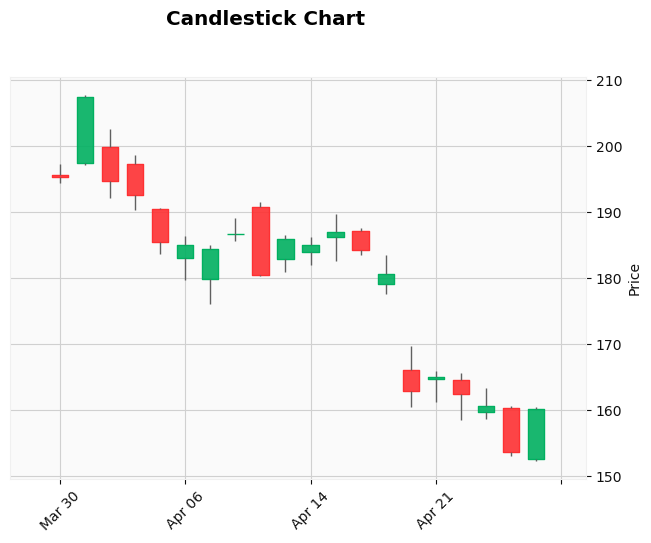

In [11]:
import mplfinance as mpf

data = {'Date': stock_data.index[60:80],
        'Open': stock_data["Open"].values[60:80],
        'High': stock_data["High"].values[60:80],
        'Low': stock_data["Low"].values[60:80],
        'Close': stock_data["Close"].values[60:80]}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

mpf.plot(df, type='candle', title='Candlestick Chart', style='yahoo', ylabel='Price')

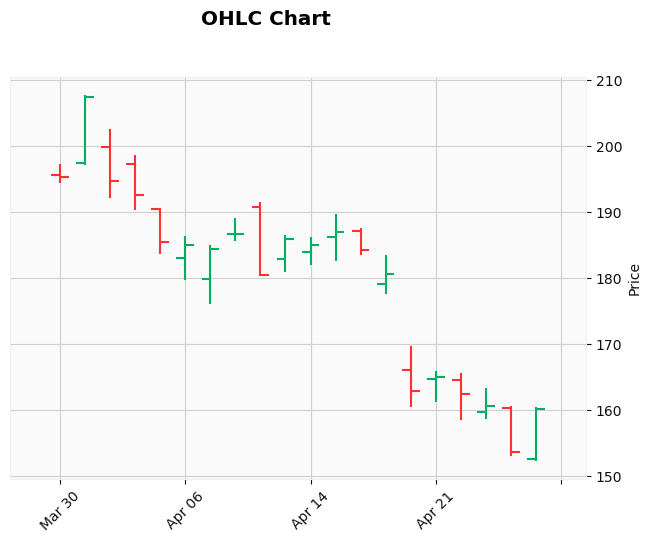

In [12]:
data = {'Date': stock_data.index[60:80],
        'Open': stock_data["Open"].values[60:80],
        'High': stock_data["High"].values[60:80],
        'Low': stock_data["Low"].values[60:80],
        'Close': stock_data["Close"].values[60:80]}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

mpf.plot(df, type='ohlc', title='OHLC Chart', style='yahoo', ylabel='Price')

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, recall_score, precision_score, accuracy_score

In [14]:
correlation = np.corrcoef(actual_stock_price.flatten(), predicted_stock_price.flatten())[0, 1]
print(f"Correlation between Actual and Predicted Prices: {correlation}")

Correlation between Actual and Predicted Prices: 0.6491854892666234


In [15]:
# Calculate performance metrics
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)
mse = mean_squared_error(actual_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 19.618960571289062
Mean Squared Error: 481.9526711769169
Root Mean Squared Error: 21.953420489229394


In [16]:
# Calculate F1-score, recall, precision, and accuracy
threshold = 0.0  # Define a threshold for classifying as 'up' or 'down (adjust as needed)
predicted_direction = np.where(predicted_stock_price > threshold, 1, 0)
actual_direction = np.where(np.array(actual_stock_price) > threshold, 1, 0)
f1 = f1_score(actual_direction, predicted_direction)
recall = recall_score(actual_direction, predicted_direction)
precision = precision_score(actual_direction, predicted_direction)
accuracy = accuracy_score(actual_direction, predicted_direction)

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")

F1 Score: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [17]:
# Create a confusion matrix
confusion = confusion_matrix(actual_direction, predicted_direction)
print("Confusion Matrix:")
print(confusion)

Confusion Matrix:
[[20]]


In [18]:
# Create a classification report
classification_rep = classification_report(actual_direction, predicted_direction)
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



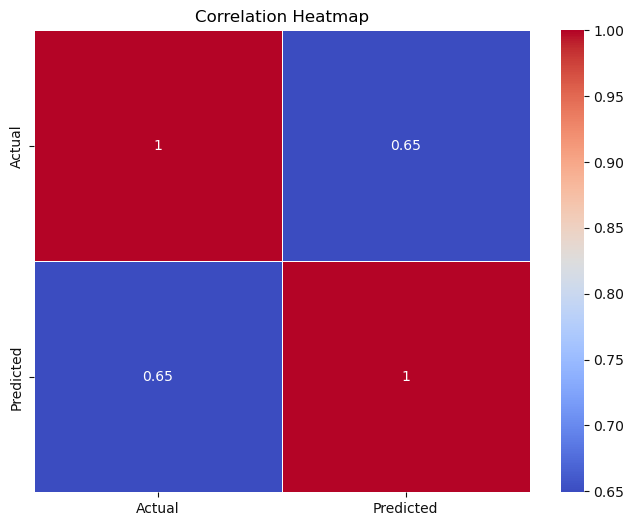

In [19]:
# Calculate correlation between actual and predicted prices
correlation = np.corrcoef(actual_stock_price.flatten(), predicted_stock_price.flatten())[0, 1]

# Create a DataFrame for the correlation matrix
correlation_matrix = pd.DataFrame({'Actual': actual_stock_price.flatten(), 'Predicted': predicted_stock_price.flatten()})

# Calculate the correlation matrix
corr_matrix = correlation_matrix.corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

In [20]:
future_date_str = input("Enter the future date for prediction (YYYY-MM-DD): ")

# Convert the future date string to a datetime object
future_date = datetime.strptime(future_date_str, "%Y-%m-%d")

# Calculate the number of past days to use for prediction (should match the model's input sequence length)
sequence_length = 60

# Extract the historical data for the specified number of past days leading up to the future date
start_date = future_date - timedelta(days=sequence_length)
end_date = future_date

# Fetch historical stock data for the specified date range
historical_data = yf.download(stock_symbol, start=start_date, end=end_date)

# Extract the "Close" prices
historical_prices = historical_data["Close"].values

# Scale the historical prices using the same scaler used for training
scaled_historical_prices = scaler.transform(historical_prices.reshape(-1, 1))

# Prepare the input sequence for prediction
X_predict = [scaled_historical_prices[-sequence_length:].flatten()]
X_predict = np.array(X_predict)

# Reshape X_predict to match the model's input shape
X_predict = X_predict.reshape(X_predict.shape[0], X_predict.shape[1], 1)

# Use the trained model to predict the stock price for the future date
predicted_price = regressor.predict(X_predict)

# Inverse transform the predicted price to get the actual stock price
predicted_price = scaler.inverse_transform(predicted_price)

# Print the predicted price for the future date
print(f"Predicted stock price on {future_date_str}: {predicted_price[0, 0]}")

Enter the future date for prediction (YYYY-MM-DD): 2024-01-01
[*********************100%%**********************]  1 of 1 completed
1/1 [==============================] - 1s 796ms/step
Predicted stock price on 2024-01-01: 130.23045349121094
